# Import Libraries

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm

In [2]:
torch.manual_seed(24)
np.random.seed(24)

# Import Dataset

In [3]:
!git clone https://github.com/a80-abbasi/DeepLearningAssignments.git

fatal: destination path 'DeepLearningAssignments' already exists and is not an empty directory.


In [32]:
!git pull origin master

remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 7 (delta 3), reused 7 (delta 3), pack-reused 0
Unpacking objects: 100% (7/7), done.
From https://github.com/a80-abbasi/DeepLearningAssignments
 * branch            master     -> FETCH_HEAD
   ca26262..353f479  master     -> origin/master
Updating ca26262..353f479
Fast-forward
 Assignment 2/HW2_data/test1.jpg | Bin 0 -> 1958 bytes
 Assignment 2/HW2_data/test2.jpg | Bin 0 -> 1937 bytes
 Assignment 2/HW2_data/test3.jpg | Bin 0 -> 1938 bytes
 3 files changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 Assignment 2/HW2_data/test1.jpg
 create mode 100644 Assignment 2/HW2_data/test2.jpg
 create mode 100644 Assignment 2/HW2_data/test3.jpg


In [4]:
%cd "./DeepLearningAssignments/Assignment 2"

/content/DeepLearningAssignments/Assignment 2


In [5]:
train_df = pd.read_csv('HW2_data/Q3_train.csv')
test_df = pd.read_csv('HW2_data/Q3_test.csv')
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [6]:
num_classes = len(np.unique(train_df['label']))
num_classes

24

It doesn't contain one of letters. So we will map them to numbers 0 to 23.

In [7]:
english_letters = [chr(ord('A') + i) for i in range(26)]
unique_labels = np.unique(np.unique(train_df['label']))
idx_to_letter = {i: english_letters[num] for i, num in enumerate(unique_labels)}
label_to_idx = {num:i for i, num in enumerate(unique_labels)}
idx_to_letter

{0: 'A',
 1: 'B',
 2: 'C',
 3: 'D',
 4: 'E',
 5: 'F',
 6: 'G',
 7: 'H',
 8: 'I',
 9: 'K',
 10: 'L',
 11: 'M',
 12: 'N',
 13: 'O',
 14: 'P',
 15: 'Q',
 16: 'R',
 17: 'S',
 18: 'T',
 19: 'U',
 20: 'V',
 21: 'W',
 22: 'X',
 23: 'Y'}

In [8]:
train_x = train_df.drop(columns=['label']).to_numpy()
test_x = test_df.drop(columns=['label']).to_numpy()
train_y = train_df['label'].map(label_to_idx).to_numpy()
test_y = test_df['label'].map(label_to_idx).to_numpy()

# Visualization

In [9]:
n_in = train_x.shape[1]
sqrt = np.sqrt(n_in).astype(int)
image_shape = (sqrt, sqrt)
image_shape

(28, 28)

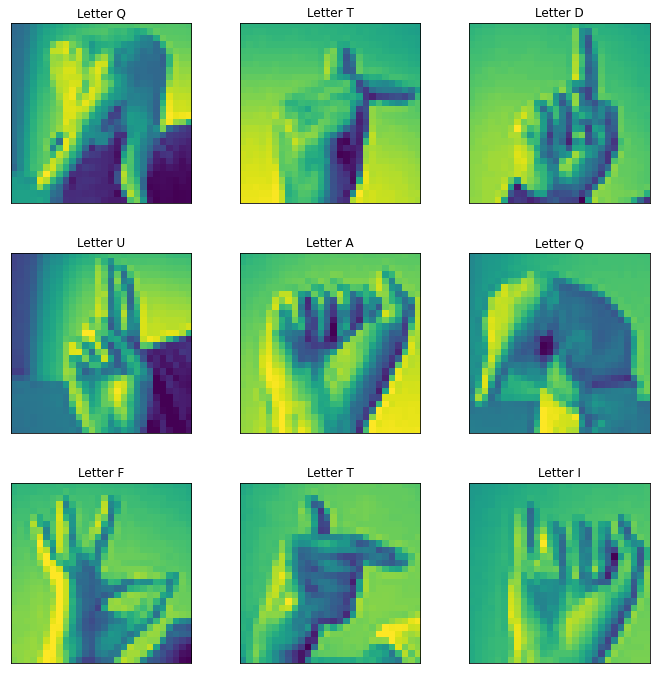

In [10]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.flat
for ax in axes:
    i = np.random.randint(0, len(train_x))
    x, y = train_x[i], train_y[i]
    img = x.reshape(image_shape)
    ax.imshow(img)
    ax.set_title(f'Letter {idx_to_letter[y]}')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout(pad=3)
plt.show()

# Dataset and Dataloaders

In [11]:
class HandLetters(torch.utils.data.Dataset):

    def __init__(self, x, y):
        self.features = torch.tensor(x).type(torch.FloatTensor)
        self.target = torch.tensor(y).type(torch.LongTensor)

    def __len__(self):
        return len(self.target)

    def __getitem__(self, item):
        x = self.features[item]
        y = self.target[item]
        return x, y

In [12]:
train_set = HandLetters(train_x, train_y)
test_set = HandLetters(test_x, test_y)

Spliting Data:

In [13]:
from torch.utils.data import random_split
train_len = int(len(train_set) * 0.8)
val_len = len(train_set) - train_len
train_set, val_set = random_split(train_set, [train_len, val_len])

Dataloaders:

In [14]:
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128, shuffle=True)
val_loader = DataLoader(val_set, batch_size=128, shuffle=True)

# Defining Model

In [15]:
from more_itertools import pairwise

class HandLettersDetector(nn.Module):

    def __init__(self, layers_inputs, dropout=False):
        super().__init__()
        layers_shape = list(pairwise(layers_inputs))
        layers = []
        for shape in layers_shape[:-1]:
            layers.append(nn.Linear(*shape))
            layers.append(nn.ReLU())
            if dropout:
                layers.append(nn.Dropout(dropout))
        layers.append(nn.Linear(*layers_shape[-1]))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        return self.layers(x)

In [16]:
layers_inputs = [n_in, 512, 256, 128, 64, num_classes]
model = HandLettersDetector(layers_inputs)
model

HandLettersDetector(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=24, bias=True)
  )
)

# Training Model

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
def accuracy(y_pred: np.ndarray, y_true: np.ndarray):
    return (y_true == y_pred).mean()

In [19]:
def one_epoch(model, loader, criterion, optimizer=None, epoch='', train=True, set_name='Train'):
    total_loss = 0
    N = len(loader.dataset)
    Y = []
    Y_pred = []
    if train:
        model.train()
    else:
        model.eval()

    with torch.set_grad_enabled(train), tqdm.tqdm(enumerate(loader)) as pbar:
        for i, (x, y) in pbar:
            if train:
                optimizer.zero_grad()

            x = x.to(device)
            y = y.to(device)
            p = model(x)

            loss = criterion(p, y)

            total_loss += loss.item() * len(x)
            pbar.set_description(f'{epoch}: {set_name} Loss: {total_loss / N:.3e}')
            if train:
                loss.backward()
                optimizer.step()

            y_pred = p.argmax(dim=-1)
            Y.append(y.cpu().numpy())
            Y_pred.append(y_pred.cpu().numpy())

    total_loss /= N

    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    acc = accuracy(Y_pred, Y)
    print(f'Accuracy of {set_name} set: {acc}')
    return total_loss, acc

In [20]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [21]:
def train_model(model, dataloaders, num_epochs, criterion, optimizer, model_name='pytroch-model'):
    train_loader, val_loader = dataloaders
    min_val_loss = np.inf
    for epoch in range(num_epochs):
        train_loss, train_acc = one_epoch(model, train_loader, criterion, optimizer, epoch, train=True, set_name='Train')
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_loss, val_acc = one_epoch(model, val_loader, criterion, epoch=epoch, train=False, set_name='Validation')
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        print('\n', '-' * 60)
        if val_loss < min_val_loss:
            min_val_loss = val_loss
            torch.save(model.state_dict(), f'{model_name}.pt')


    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='val')
    plt.title('loss history of training and val sets')
    plt.legend()
    plt.show()

    plt.plot(train_accuracies, label='train')
    plt.plot(val_accuracies, label='val')
    plt.title('Accuracy history of training and val sets')
    plt.legend()
    plt.show()

    model.load_state_dict(torch.load(f'{model_name}.pt'))
    return model, min_val_loss

Training with SGD:

0: Train Loss: 2.876e+00: : 172it [00:01, 86.20it/s] 


Accuracy of Train set: 0.177153523948279


0: Validation Loss: 2.767e+00: : 43it [00:00, 165.70it/s]


Accuracy of Validation set: 0.2103441995993444

 ------------------------------------------------------------


1: Train Loss: 2.266e+00: : 172it [00:01, 115.49it/s]


Accuracy of Train set: 0.34611181934073937


1: Validation Loss: 2.062e+00: : 43it [00:00, 132.99it/s]


Accuracy of Validation set: 0.3882717173556729

 ------------------------------------------------------------


2: Train Loss: 1.804e+00: : 172it [00:01, 88.87it/s]


Accuracy of Train set: 0.4580677472227281


2: Validation Loss: 1.576e+00: : 43it [00:00, 73.71it/s]


Accuracy of Validation set: 0.5386996904024768

 ------------------------------------------------------------


3: Train Loss: 1.483e+00: : 172it [00:01, 96.82it/s]


Accuracy of Train set: 0.5541795665634675


3: Validation Loss: 1.307e+00: : 43it [00:00, 112.00it/s]


Accuracy of Validation set: 0.6015297759970861

 ------------------------------------------------------------


4: Train Loss: 1.243e+00: : 172it [00:02, 80.33it/s]


Accuracy of Train set: 0.6278455654707703


4: Validation Loss: 1.234e+00: : 43it [00:00, 117.01it/s]


Accuracy of Validation set: 0.616463303587689

 ------------------------------------------------------------


5: Train Loss: 1.082e+00: : 172it [00:02, 85.10it/s]


Accuracy of Train set: 0.6758331815698415


5: Validation Loss: 9.863e-01: : 43it [00:00, 112.17it/s]


Accuracy of Validation set: 0.6995082862866508

 ------------------------------------------------------------


6: Train Loss: 9.274e-01: : 172it [00:02, 78.27it/s]


Accuracy of Train set: 0.7276452376616281


6: Validation Loss: 9.507e-01: : 43it [00:00, 111.63it/s]


Accuracy of Validation set: 0.6767437625204881

 ------------------------------------------------------------


7: Train Loss: 8.065e-01: : 172it [00:02, 85.16it/s]


Accuracy of Train set: 0.7642505918776179


7: Validation Loss: 7.022e-01: : 43it [00:00, 120.01it/s]


Accuracy of Validation set: 0.810963394645784

 ------------------------------------------------------------


8: Train Loss: 7.259e-01: : 172it [00:02, 66.92it/s]


Accuracy of Train set: 0.7900200327809143


8: Validation Loss: 6.228e-01: : 43it [00:00, 104.26it/s]


Accuracy of Validation set: 0.8317246403205245

 ------------------------------------------------------------


9: Train Loss: 6.169e-01: : 172it [00:01, 125.00it/s]


Accuracy of Train set: 0.8274449098524859


9: Validation Loss: 5.556e-01: : 43it [00:00, 165.94it/s]


Accuracy of Validation set: 0.8408304498269896

 ------------------------------------------------------------


10: Train Loss: 5.592e-01: : 172it [00:01, 130.14it/s]


Accuracy of Train set: 0.8425150245856856


10: Validation Loss: 6.774e-01: : 43it [00:00, 161.21it/s]


Accuracy of Validation set: 0.7881988708796211

 ------------------------------------------------------------


11: Train Loss: 4.794e-01: : 172it [00:01, 130.70it/s]


Accuracy of Train set: 0.8679657621562556


11: Validation Loss: 5.007e-01: : 43it [00:00, 154.89it/s]


Accuracy of Validation set: 0.8648697869240576

 ------------------------------------------------------------


12: Train Loss: 4.191e-01: : 172it [00:01, 128.86it/s]


Accuracy of Train set: 0.8886359497359315


12: Validation Loss: 8.437e-01: : 43it [00:00, 164.83it/s]


Accuracy of Validation set: 0.718266253869969

 ------------------------------------------------------------


13: Train Loss: 3.845e-01: : 172it [00:01, 135.32it/s]


Accuracy of Train set: 0.8971954106720087


13: Validation Loss: 4.011e-01: : 43it [00:00, 163.31it/s]


Accuracy of Validation set: 0.8890912402112547

 ------------------------------------------------------------


14: Train Loss: 3.353e-01: : 172it [00:01, 129.22it/s]


Accuracy of Train set: 0.9122655254052086


14: Validation Loss: 3.220e-01: : 43it [00:00, 163.66it/s]


Accuracy of Validation set: 0.9003824439992716

 ------------------------------------------------------------


15: Train Loss: 2.803e-01: : 172it [00:01, 129.80it/s]


Accuracy of Train set: 0.9325259515570934


15: Validation Loss: 2.606e-01: : 43it [00:00, 155.94it/s]


Accuracy of Validation set: 0.9318885448916409

 ------------------------------------------------------------


16: Train Loss: 3.006e-01: : 172it [00:01, 126.11it/s]


Accuracy of Train set: 0.927153523948279


16: Validation Loss: 2.553e-01: : 43it [00:00, 161.65it/s]


Accuracy of Validation set: 0.9369877982152613

 ------------------------------------------------------------


17: Train Loss: 2.061e-01: : 172it [00:01, 126.27it/s]


Accuracy of Train set: 0.9577945729375341


17: Validation Loss: 3.812e-01: : 43it [00:00, 150.53it/s]


Accuracy of Validation set: 0.8708796211983245

 ------------------------------------------------------------


18: Train Loss: 3.891e-01: : 172it [00:01, 121.64it/s]


Accuracy of Train set: 0.9150427973046804


18: Validation Loss: 1.947e-01: : 43it [00:00, 144.23it/s]


Accuracy of Validation set: 0.9661263886359497

 ------------------------------------------------------------


19: Train Loss: 1.653e-01: : 172it [00:01, 118.11it/s]


Accuracy of Train set: 0.9704061191039883


19: Validation Loss: 2.585e-01: : 43it [00:00, 160.40it/s]


Accuracy of Validation set: 0.9335275906028045

 ------------------------------------------------------------


20: Train Loss: 2.295e-01: : 172it [00:01, 127.02it/s]


Accuracy of Train set: 0.9554725915133856


20: Validation Loss: 1.537e-01: : 43it [00:00, 162.62it/s]


Accuracy of Validation set: 0.9735931524312511

 ------------------------------------------------------------


21: Train Loss: 1.280e-01: : 172it [00:01, 123.56it/s]


Accuracy of Train set: 0.980149335275906


21: Validation Loss: 1.220e-01: : 43it [00:00, 160.29it/s]


Accuracy of Validation set: 0.9816062647969405

 ------------------------------------------------------------


22: Train Loss: 1.455e-01: : 172it [00:01, 122.09it/s]


Accuracy of Train set: 0.9738663267164451


22: Validation Loss: 1.075e-01: : 43it [00:00, 157.23it/s]


Accuracy of Validation set: 0.9857949371699144

 ------------------------------------------------------------


23: Train Loss: 9.205e-02: : 172it [00:01, 118.56it/s]


Accuracy of Train set: 0.9911673647787288


23: Validation Loss: 7.918e-02: : 43it [00:00, 101.09it/s]


Accuracy of Validation set: 0.9970861409579311

 ------------------------------------------------------------


24: Train Loss: 8.227e-02: : 172it [00:02, 80.33it/s]


Accuracy of Train set: 0.9931706428701511


24: Validation Loss: 8.654e-02: : 43it [00:00, 97.54it/s] 


Accuracy of Validation set: 0.99216900382444

 ------------------------------------------------------------


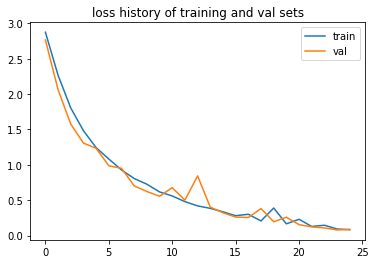

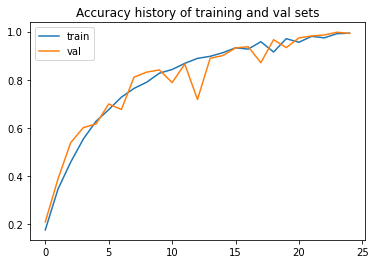

In [22]:
train_losses.clear()
val_losses.clear()
train_accuracies.clear()
val_accuracies.clear()

# Training config
lr = 0.001
model = HandLettersDetector(layers_inputs).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)
model, min_val_loss = train_model(model, [train_loader, val_loader], 25, criterion, optimizer)

In [23]:
min_val_loss

0.07917511907879869

In [24]:
test_loss, test_acc = one_epoch(model, test_loader, criterion, train=False, set_name='Test')

: Test Loss: 8.192e-01: : 57it [00:00, 114.21it/s]

Accuracy of Test set: 0.7571109871723368


Training with Adam:

0: Train Loss: 2.488e+00: : 172it [00:02, 73.10it/s]


Accuracy of Train set: 0.27335640138408307


0: Validation Loss: 1.784e+00: : 43it [00:00, 117.39it/s]


Accuracy of Validation set: 0.4591149153159716

 ------------------------------------------------------------


1: Train Loss: 1.373e+00: : 172it [00:02, 67.78it/s]


Accuracy of Train set: 0.5896466945911492


1: Validation Loss: 1.005e+00: : 43it [00:00, 91.61it/s]


Accuracy of Validation set: 0.7066108177016936

 ------------------------------------------------------------


2: Train Loss: 8.634e-01: : 172it [00:02, 66.67it/s]


Accuracy of Train set: 0.748178838098707


2: Validation Loss: 7.361e-01: : 43it [00:00, 103.46it/s]


Accuracy of Validation set: 0.7741759242396649

 ------------------------------------------------------------


3: Train Loss: 5.995e-01: : 172it [00:02, 74.17it/s]


Accuracy of Train set: 0.8292205427062466


3: Validation Loss: 4.985e-01: : 43it [00:00, 159.99it/s]


Accuracy of Validation set: 0.8685121107266436

 ------------------------------------------------------------


4: Train Loss: 4.420e-01: : 172it [00:01, 116.29it/s]


Accuracy of Train set: 0.8737024221453287


4: Validation Loss: 3.953e-01: : 43it [00:00, 163.64it/s]


Accuracy of Validation set: 0.8930977963940995

 ------------------------------------------------------------


5: Train Loss: 2.834e-01: : 172it [00:01, 119.22it/s]


Accuracy of Train set: 0.9327080677472227


5: Validation Loss: 2.418e-01: : 43it [00:00, 166.53it/s]


Accuracy of Validation set: 0.9406301220178473

 ------------------------------------------------------------


6: Train Loss: 1.850e-01: : 172it [00:01, 116.34it/s]


Accuracy of Train set: 0.9635767619741396


6: Validation Loss: 1.553e-01: : 43it [00:00, 170.84it/s]


Accuracy of Validation set: 0.9712256419595702

 ------------------------------------------------------------


7: Train Loss: 1.431e-01: : 172it [00:01, 116.94it/s]


Accuracy of Train set: 0.9725459843380077


7: Validation Loss: 1.022e-01: : 43it [00:00, 153.88it/s]


Accuracy of Validation set: 0.9912584228737935

 ------------------------------------------------------------


8: Train Loss: 9.460e-02: : 172it [00:01, 116.88it/s]


Accuracy of Train set: 0.9877071571662721


8: Validation Loss: 5.962e-02: : 43it [00:00, 164.10it/s]


Accuracy of Validation set: 0.998178838098707

 ------------------------------------------------------------


9: Train Loss: 6.127e-02: : 172it [00:01, 115.67it/s]


Accuracy of Train set: 0.9951283919140411


9: Validation Loss: 5.607e-02: : 43it [00:00, 163.28it/s]


Accuracy of Validation set: 0.9967219085776725

 ------------------------------------------------------------


10: Train Loss: 4.080e-02: : 172it [00:01, 114.68it/s]


Accuracy of Train set: 0.9982243671462393


10: Validation Loss: 3.728e-02: : 43it [00:00, 159.46it/s]


Accuracy of Validation set: 0.9978146057184484

 ------------------------------------------------------------


11: Train Loss: 3.210e-02: : 172it [00:01, 117.16it/s]


Accuracy of Train set: 0.9981333090511747


11: Validation Loss: 2.282e-02: : 43it [00:00, 158.64it/s]


Accuracy of Validation set: 0.9990894190493534

 ------------------------------------------------------------


12: Train Loss: 1.879e-02: : 172it [00:01, 114.14it/s]


Accuracy of Train set: 0.9999089419049354


12: Validation Loss: 1.834e-02: : 43it [00:00, 165.04it/s]


Accuracy of Validation set: 0.9996357676197414

 ------------------------------------------------------------


13: Train Loss: 3.813e-02: : 172it [00:01, 114.14it/s]


Accuracy of Train set: 0.9944909852485886


13: Validation Loss: 2.234e-02: : 43it [00:00, 157.56it/s]


Accuracy of Validation set: 0.9990894190493534

 ------------------------------------------------------------


14: Train Loss: 1.128e-02: : 172it [00:01, 99.74it/s]


Accuracy of Train set: 0.9998178838098707


14: Validation Loss: 9.384e-03: : 43it [00:00, 141.05it/s]


Accuracy of Validation set: 1.0

 ------------------------------------------------------------


15: Train Loss: 8.418e-03: : 172it [00:01, 106.69it/s]


Accuracy of Train set: 0.9999544709524677


15: Validation Loss: 9.707e-03: : 43it [00:00, 161.91it/s]


Accuracy of Validation set: 1.0

 ------------------------------------------------------------


16: Train Loss: 7.120e-03: : 172it [00:01, 115.29it/s]


Accuracy of Train set: 1.0


16: Validation Loss: 7.881e-03: : 43it [00:00, 162.70it/s]


Accuracy of Validation set: 1.0

 ------------------------------------------------------------


17: Train Loss: 5.892e-03: : 172it [00:01, 114.64it/s]


Accuracy of Train set: 1.0


17: Validation Loss: 7.659e-03: : 43it [00:00, 163.88it/s]


Accuracy of Validation set: 1.0

 ------------------------------------------------------------


18: Train Loss: 4.760e-03: : 172it [00:01, 114.57it/s]


Accuracy of Train set: 1.0


18: Validation Loss: 4.530e-03: : 43it [00:00, 161.88it/s]


Accuracy of Validation set: 1.0

 ------------------------------------------------------------


19: Train Loss: 4.470e-03: : 172it [00:01, 115.24it/s]


Accuracy of Train set: 1.0


19: Validation Loss: 3.618e-03: : 43it [00:00, 158.91it/s]


Accuracy of Validation set: 1.0

 ------------------------------------------------------------


20: Train Loss: 3.213e-03: : 172it [00:01, 114.88it/s]


Accuracy of Train set: 1.0


20: Validation Loss: 2.925e-03: : 43it [00:00, 154.47it/s]


Accuracy of Validation set: 1.0

 ------------------------------------------------------------


21: Train Loss: 2.613e-03: : 172it [00:01, 113.86it/s]


Accuracy of Train set: 1.0


21: Validation Loss: 2.872e-03: : 43it [00:00, 156.42it/s]


Accuracy of Validation set: 1.0

 ------------------------------------------------------------


22: Train Loss: 2.751e-03: : 172it [00:01, 112.77it/s]


Accuracy of Train set: 1.0


22: Validation Loss: 2.468e-03: : 43it [00:00, 159.15it/s]


Accuracy of Validation set: 1.0

 ------------------------------------------------------------


23: Train Loss: 1.924e-03: : 172it [00:01, 112.62it/s]


Accuracy of Train set: 1.0


23: Validation Loss: 1.869e-03: : 43it [00:00, 158.81it/s]


Accuracy of Validation set: 1.0

 ------------------------------------------------------------


24: Train Loss: 4.125e-01: : 172it [00:01, 112.13it/s]


Accuracy of Train set: 0.8935530868694227


24: Validation Loss: 1.816e-01: : 43it [00:00, 155.39it/s]


Accuracy of Validation set: 0.9484611181934074

 ------------------------------------------------------------


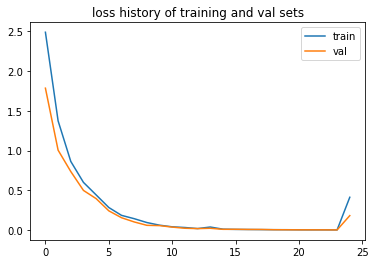

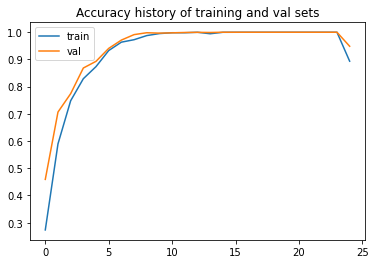

In [25]:
train_losses.clear()
val_losses.clear()
train_accuracies.clear()
val_accuracies.clear()

# Training config
lr = 0.0001
model = HandLettersDetector(layers_inputs).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
model, min_val_loss = train_model(model, [train_loader, val_loader], 25, criterion, optimizer)

In [26]:
min_val_loss

0.0018694544905748138

In [27]:
test_loss, test_acc = one_epoch(model, test_loader, criterion, train=False, set_name='Test')

: Test Loss: 1.181e+00: : 57it [00:00, 135.47it/s]

Accuracy of Test set: 0.7783045175683212


Training with Dropout:

0: Train Loss: 3.388e+00: : 172it [00:01, 116.19it/s]


Accuracy of Train set: 0.057047896558004005


0: Validation Loss: 3.096e+00: : 43it [00:00, 167.78it/s]


Accuracy of Validation set: 0.11801129120378802

 ------------------------------------------------------------


1: Train Loss: 3.009e+00: : 172it [00:02, 74.18it/s]


Accuracy of Train set: 0.11414132216354034


1: Validation Loss: 2.662e+00: : 43it [00:00, 165.24it/s]


Accuracy of Validation set: 0.2724458204334365

 ------------------------------------------------------------


2: Train Loss: 2.603e+00: : 172it [00:01, 113.07it/s]


Accuracy of Train set: 0.20711163722454926


2: Validation Loss: 2.093e+00: : 43it [00:00, 163.20it/s]


Accuracy of Validation set: 0.3813513021307594

 ------------------------------------------------------------


3: Train Loss: 2.242e+00: : 172it [00:01, 113.92it/s]


Accuracy of Train set: 0.2869240575487161


3: Validation Loss: 1.736e+00: : 43it [00:00, 169.04it/s]


Accuracy of Validation set: 0.4946275723911856

 ------------------------------------------------------------


4: Train Loss: 1.962e+00: : 172it [00:01, 114.03it/s]


Accuracy of Train set: 0.36081770169368055


4: Validation Loss: 1.383e+00: : 43it [00:00, 171.73it/s]


Accuracy of Validation set: 0.5927881988708796

 ------------------------------------------------------------


5: Train Loss: 1.723e+00: : 172it [00:01, 112.78it/s]


Accuracy of Train set: 0.4319796029867055


5: Validation Loss: 1.165e+00: : 43it [00:00, 145.48it/s]


Accuracy of Validation set: 0.6674558368238936

 ------------------------------------------------------------


6: Train Loss: 1.527e+00: : 172it [00:01, 107.52it/s]


Accuracy of Train set: 0.4943088690584593


6: Validation Loss: 9.973e-01: : 43it [00:00, 159.35it/s]


Accuracy of Validation set: 0.6951374977235476

 ------------------------------------------------------------


7: Train Loss: 1.357e+00: : 172it [00:01, 108.57it/s]


Accuracy of Train set: 0.5497177199052996


7: Validation Loss: 8.588e-01: : 43it [00:00, 157.81it/s]


Accuracy of Validation set: 0.7559643052267346

 ------------------------------------------------------------


8: Train Loss: 1.235e+00: : 172it [00:01, 111.90it/s]


Accuracy of Train set: 0.5871881260244036


8: Validation Loss: 7.277e-01: : 43it [00:00, 165.23it/s]


Accuracy of Validation set: 0.7869240575487161

 ------------------------------------------------------------


9: Train Loss: 1.100e+00: : 172it [00:01, 111.44it/s]


Accuracy of Train set: 0.6242942997632489


9: Validation Loss: 6.510e-01: : 43it [00:00, 149.80it/s]


Accuracy of Validation set: 0.8209797851028956

 ------------------------------------------------------------


10: Train Loss: 1.007e+00: : 172it [00:01, 111.15it/s]


Accuracy of Train set: 0.6559825168457476


10: Validation Loss: 5.798e-01: : 43it [00:00, 157.82it/s]


Accuracy of Validation set: 0.8419231469677654

 ------------------------------------------------------------


11: Train Loss: 9.086e-01: : 172it [00:01, 109.56it/s]


Accuracy of Train set: 0.6876707339282462


11: Validation Loss: 4.822e-01: : 43it [00:00, 161.44it/s]


Accuracy of Validation set: 0.8743398288107813

 ------------------------------------------------------------


12: Train Loss: 8.266e-01: : 172it [00:01, 106.00it/s]


Accuracy of Train set: 0.7143962848297214


12: Validation Loss: 3.902e-01: : 43it [00:00, 145.88it/s]


Accuracy of Validation set: 0.8905481697322892

 ------------------------------------------------------------


13: Train Loss: 7.448e-01: : 172it [00:01, 95.07it/s]


Accuracy of Train set: 0.7467219085776725


13: Validation Loss: 3.768e-01: : 43it [00:00, 130.56it/s]


Accuracy of Validation set: 0.9062101620834092

 ------------------------------------------------------------


14: Train Loss: 7.093e-01: : 172it [00:01, 113.24it/s]


Accuracy of Train set: 0.756419595702058


14: Validation Loss: 3.212e-01: : 43it [00:00, 163.61it/s]


Accuracy of Validation set: 0.9298852668002185

 ------------------------------------------------------------


15: Train Loss: 6.414e-01: : 172it [00:01, 113.47it/s]


Accuracy of Train set: 0.7754052085230377


15: Validation Loss: 2.774e-01: : 43it [00:00, 152.55it/s]


Accuracy of Validation set: 0.9338918229830632

 ------------------------------------------------------------


16: Train Loss: 6.096e-01: : 172it [00:01, 111.30it/s]


Accuracy of Train set: 0.7900655618284466


16: Validation Loss: 2.259e-01: : 43it [00:00, 159.81it/s]


Accuracy of Validation set: 0.9471863048625023

 ------------------------------------------------------------


17: Train Loss: 5.667e-01: : 172it [00:01, 95.34it/s]


Accuracy of Train set: 0.8054088508468403


17: Validation Loss: 2.139e-01: : 43it [00:00, 129.87it/s]


Accuracy of Validation set: 0.9537424877071572

 ------------------------------------------------------------


18: Train Loss: 5.073e-01: : 172it [00:02, 77.35it/s]


Accuracy of Train set: 0.8270351484246949


18: Validation Loss: 1.893e-01: : 43it [00:00, 158.72it/s]


Accuracy of Validation set: 0.952467674376252

 ------------------------------------------------------------


19: Train Loss: 4.828e-01: : 172it [00:01, 111.82it/s]


Accuracy of Train set: 0.8336823893644145


19: Validation Loss: 1.526e-01: : 43it [00:00, 161.41it/s]


Accuracy of Validation set: 0.9721362229102167

 ------------------------------------------------------------


20: Train Loss: 4.511e-01: : 172it [00:01, 111.23it/s]


Accuracy of Train set: 0.8479329812420324


20: Validation Loss: 1.498e-01: : 43it [00:00, 160.74it/s]


Accuracy of Validation set: 0.9686760152977599

 ------------------------------------------------------------


21: Train Loss: 4.019e-01: : 172it [00:01, 106.18it/s]


Accuracy of Train set: 0.8642323802586049


21: Validation Loss: 1.251e-01: : 43it [00:00, 157.38it/s]


Accuracy of Validation set: 0.9739573848115097

 ------------------------------------------------------------


22: Train Loss: 4.059e-01: : 172it [00:01, 111.17it/s]


Accuracy of Train set: 0.8628665088326353


22: Validation Loss: 1.301e-01: : 43it [00:00, 158.87it/s]


Accuracy of Validation set: 0.9732289200509925

 ------------------------------------------------------------


23: Train Loss: 3.693e-01: : 172it [00:01, 109.04it/s]


Accuracy of Train set: 0.8761609907120743


23: Validation Loss: 9.353e-02: : 43it [00:00, 156.35it/s]


Accuracy of Validation set: 0.9863412857403023

 ------------------------------------------------------------


24: Train Loss: 3.382e-01: : 172it [00:01, 111.64it/s]


Accuracy of Train set: 0.8854033873611364


24: Validation Loss: 8.367e-02: : 43it [00:00, 158.89it/s]


Accuracy of Validation set: 0.9874339828810781

 ------------------------------------------------------------


25: Train Loss: 3.224e-01: : 172it [00:01, 111.56it/s]


Accuracy of Train set: 0.8911855763977418


25: Validation Loss: 7.632e-02: : 43it [00:00, 158.00it/s]


Accuracy of Validation set: 0.9874339828810781

 ------------------------------------------------------------


26: Train Loss: 3.083e-01: : 172it [00:01, 111.30it/s]


Accuracy of Train set: 0.8984246949553816


26: Validation Loss: 6.897e-02: : 43it [00:00, 159.31it/s]


Accuracy of Validation set: 0.9908941904935349

 ------------------------------------------------------------


27: Train Loss: 3.036e-01: : 172it [00:01, 110.99it/s]


Accuracy of Train set: 0.8981970497177199


27: Validation Loss: 7.034e-02: : 43it [00:00, 148.98it/s]


Accuracy of Validation set: 0.9876160990712074

 ------------------------------------------------------------


28: Train Loss: 2.915e-01: : 172it [00:01, 109.55it/s]


Accuracy of Train set: 0.9052540520852304


28: Validation Loss: 5.369e-02: : 43it [00:00, 153.51it/s]


Accuracy of Validation set: 0.9907120743034056

 ------------------------------------------------------------


29: Train Loss: 2.682e-01: : 172it [00:01, 109.45it/s]


Accuracy of Train set: 0.9124021125478055


29: Validation Loss: 5.426e-02: : 43it [00:00, 156.45it/s]


Accuracy of Validation set: 0.9899836095428883

 ------------------------------------------------------------


30: Train Loss: 2.405e-01: : 172it [00:01, 109.99it/s]


Accuracy of Train set: 0.9223729739573848


30: Validation Loss: 4.132e-02: : 43it [00:00, 162.46it/s]


Accuracy of Validation set: 0.9943543981059916

 ------------------------------------------------------------


31: Train Loss: 2.365e-01: : 172it [00:01, 111.63it/s]


Accuracy of Train set: 0.9223274449098525


31: Validation Loss: 4.743e-02: : 43it [00:00, 154.03it/s]


Accuracy of Validation set: 0.9899836095428883

 ------------------------------------------------------------


32: Train Loss: 2.198e-01: : 172it [00:01, 108.36it/s]


Accuracy of Train set: 0.9275632853760699


32: Validation Loss: 4.820e-02: : 43it [00:00, 145.63it/s]


Accuracy of Validation set: 0.9908941904935349

 ------------------------------------------------------------


33: Train Loss: 2.161e-01: : 172it [00:01, 109.04it/s]


Accuracy of Train set: 0.9285649244217811


33: Validation Loss: 4.840e-02: : 43it [00:00, 153.60it/s]


Accuracy of Validation set: 0.9910763066836642

 ------------------------------------------------------------


34: Train Loss: 2.057e-01: : 172it [00:01, 106.59it/s]


Accuracy of Train set: 0.9337097067929339


34: Validation Loss: 3.064e-02: : 43it [00:00, 152.16it/s]


Accuracy of Validation set: 0.9941722819158623

 ------------------------------------------------------------


35: Train Loss: 1.959e-01: : 172it [00:01, 107.80it/s]


Accuracy of Train set: 0.9380349663085048


35: Validation Loss: 2.419e-02: : 43it [00:00, 156.01it/s]


Accuracy of Validation set: 0.998178838098707

 ------------------------------------------------------------


36: Train Loss: 1.813e-01: : 172it [00:01, 94.49it/s]


Accuracy of Train set: 0.9422236386814787


36: Validation Loss: 2.611e-02: : 43it [00:00, 145.73it/s]


Accuracy of Validation set: 0.9974503733381898

 ------------------------------------------------------------


37: Train Loss: 1.965e-01: : 172it [00:01, 97.37it/s] 


Accuracy of Train set: 0.9383991986887634


37: Validation Loss: 2.238e-02: : 43it [00:00, 153.10it/s]


Accuracy of Validation set: 0.9965397923875432

 ------------------------------------------------------------


38: Train Loss: 1.885e-01: : 172it [00:01, 105.73it/s]


Accuracy of Train set: 0.9400837734474595


38: Validation Loss: 3.570e-02: : 43it [00:00, 150.74it/s]


Accuracy of Validation set: 0.9892551447823712

 ------------------------------------------------------------


39: Train Loss: 1.692e-01: : 172it [00:01, 109.80it/s]


Accuracy of Train set: 0.9472318339100346


39: Validation Loss: 1.934e-02: : 43it [00:00, 154.76it/s]


Accuracy of Validation set: 0.998178838098707

 ------------------------------------------------------------


40: Train Loss: 1.590e-01: : 172it [00:01, 108.05it/s]


Accuracy of Train set: 0.9510107448552176


40: Validation Loss: 1.540e-02: : 43it [00:00, 141.75it/s]


Accuracy of Validation set: 0.9989073028592241

 ------------------------------------------------------------


41: Train Loss: 1.738e-01: : 172it [00:01, 108.54it/s]


Accuracy of Train set: 0.9456383172464032


41: Validation Loss: 2.750e-02: : 43it [00:00, 158.58it/s]


Accuracy of Validation set: 0.9938080495356038

 ------------------------------------------------------------


42: Train Loss: 1.813e-01: : 172it [00:01, 107.27it/s]


Accuracy of Train set: 0.9421325805864141


42: Validation Loss: 1.807e-02: : 43it [00:00, 148.74it/s]


Accuracy of Validation set: 0.9983609542888363

 ------------------------------------------------------------


43: Train Loss: 1.641e-01: : 172it [00:01, 108.70it/s]


Accuracy of Train set: 0.9473684210526315


43: Validation Loss: 1.989e-02: : 43it [00:00, 148.09it/s]


Accuracy of Validation set: 0.9979967219085777

 ------------------------------------------------------------


44: Train Loss: 1.636e-01: : 172it [00:01, 106.36it/s]


Accuracy of Train set: 0.9498269896193772


44: Validation Loss: 1.768e-02: : 43it [00:00, 150.76it/s]


Accuracy of Validation set: 0.9985430704789656

 ------------------------------------------------------------


45: Train Loss: 1.417e-01: : 172it [00:01, 103.50it/s]


Accuracy of Train set: 0.9560644691313058


45: Validation Loss: 9.976e-03: : 43it [00:00, 163.84it/s]


Accuracy of Validation set: 0.9994536514296121

 ------------------------------------------------------------


46: Train Loss: 1.447e-01: : 172it [00:01, 106.57it/s]


Accuracy of Train set: 0.9552904753232563


46: Validation Loss: 1.266e-02: : 43it [00:00, 160.63it/s]


Accuracy of Validation set: 0.9987251866690949

 ------------------------------------------------------------


47: Train Loss: 1.291e-01: : 172it [00:01, 109.22it/s]


Accuracy of Train set: 0.9595246767437625


47: Validation Loss: 1.289e-02: : 43it [00:00, 154.33it/s]


Accuracy of Validation set: 0.9998178838098707

 ------------------------------------------------------------


48: Train Loss: 1.439e-01: : 172it [00:01, 106.06it/s]


Accuracy of Train set: 0.9542433072300127


48: Validation Loss: 2.240e-02: : 43it [00:00, 149.73it/s]


Accuracy of Validation set: 0.9974503733381898

 ------------------------------------------------------------


49: Train Loss: 1.410e-01: : 172it [00:01, 104.53it/s]


Accuracy of Train set: 0.9578401019850665


49: Validation Loss: 3.395e-02: : 43it [00:00, 151.61it/s]


Accuracy of Validation set: 0.9896193771626297

 ------------------------------------------------------------


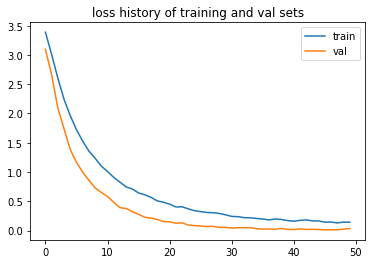

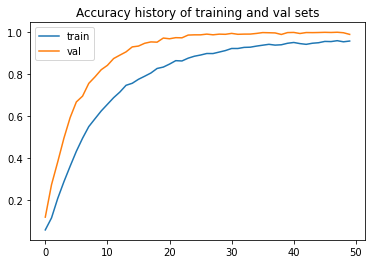

In [28]:
train_losses.clear()
val_losses.clear()
train_accuracies.clear()
val_accuracies.clear()

# Training config
lr = 8e-5
model = HandLettersDetector(layers_inputs, dropout=0.25).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
model, min_val_loss = train_model(model, [train_loader, val_loader], 50, criterion, optimizer)

In [29]:
min_val_loss

0.009975888150667985

In [30]:
test_loss, test_acc = one_epoch(model, test_loader, criterion, train=False, set_name='Test')

: Test Loss: 8.507e-01: : 57it [00:00, 177.55it/s]

Accuracy of Test set: 0.7992191857222533


In [35]:
from PIL import Image
from torchvision.transforms import ToTensor, Grayscale
totensor = ToTensor()
grayscale = Grayscale()

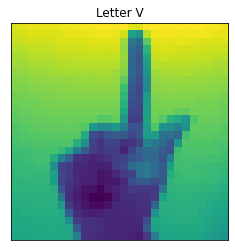

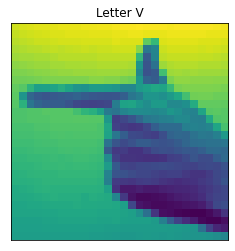

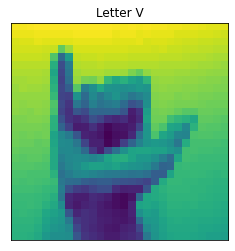

In [47]:
images = [f'HW2_data/test{i}.jpg' for i in range(1, 4)]
for iamage_name in images:
    img = grayscale(Image.open(iamage_name))
    plt.imshow(img)
    with torch.no_grad():
        x = totensor(img).view(1, -1)
        x = x.to(device)
        p = model(x).cpu().numpy()
        y = np.argmax(p)
        plt.title(f'Letter {idx_to_letter[y]}')
        plt.xticks([])
        plt.yticks([])
        plt.show()